In [1]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler , QuantileTransformer , normalize
from sklearn.metrics import r2_score
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras import metrics, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
epochs = 1000
tester_units = [0]
shared_units = Volume_units = ema6_units = ema12_units = ema26_units = macd_units = wrsi_units = K_units = D_units = closed_units = 64
batch_size = 256
early_stop = EarlyStopping(monitor='val_dense_9_loss', patience=20)
model_cp = ModelCheckpoint("model_units_"+str(shared_units)+"batch_"+str(batch_size)+".cp",monitor='dense_9_loss',save_best_only=True)
def splitData(X,Y,rate,data_date=[]):
    X_train = X[:int(X.shape[0]*rate)]
    Y_train = Y[:int(Y.shape[0]*rate)]
    X_val = X[int(X.shape[0]*rate):]
    Y_val = Y[int(Y.shape[0]*rate)-1:-1]
    if len(data_date!=0):
        dates_train = data_date[:int(X.shape[0]*rate)]
        dates_val = data_date[int(X.shape[0]*rate):]
        return X_train, Y_train, X_val, Y_val, dates_train,dates_val
    return X_train, Y_train, X_val, Y_val

df = pd.read_csv("data/indicators/2317_indicators.csv")
#print(df)
mms = QuantileTransformer()
sc_data = mms.fit_transform(df.drop('date',axis=1).values)
#X_train = df.values
X_train = sc_data
#y_train = df.loc[1:].values
y_train = sc_data[1:]
X_train , Y_train , X_val , Y_val, dates_tran, dates_val = splitData(X_train,y_train,0.8,df.iloc[:,[0]].values)

X_train_df = pd.DataFrame(data=X_train)
X_val_df = pd.DataFrame(data=X_val)

shared_lstm_init = LSTM(shared_units,activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer = regularizers.l2(0.01),return_sequences = True)
shared_lstm1 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=True)
shared_lstm2 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=True)
shared_lstm3 = LSTM(shared_units,kernel_regularizer=regularizers.l2(0.01),return_sequences=False)

Normalization

In [3]:
"""
sc_X = QuantileTransformer()
X_train_sc = sc_X.fit_transform(X_train)
print(X_train.shape)
X_val_sc = sc_X.transform(X_val)
X_train_df = pd.DataFrame(data=X_train_sc)
X_val_df = pd.DataFrame(data=X_val_sc)
sc = MinMaxScaler(feature_range=(np.min(df.loc[:,'closed'].values),np.max(df.loc[:,'closed'].values)))
a = np.array(X_train_df.loc[:,1].values)
a = a.reshape(a.shape[0],1)
b = np.array(X_val_df.loc[:,1].values)
b = b.reshape(b.shape[0],1)
a = sc.fit_transform(a)
b = sc.transform(b)"""

"\nsc_X = QuantileTransformer()\nX_train_sc = sc_X.fit_transform(X_train)\nprint(X_train.shape)\nX_val_sc = sc_X.transform(X_val)\nX_train_df = pd.DataFrame(data=X_train_sc)\nX_val_df = pd.DataFrame(data=X_val_sc)\nsc = MinMaxScaler(feature_range=(np.min(df.loc[:,'closed'].values),np.max(df.loc[:,'closed'].values)))\na = np.array(X_train_df.loc[:,1].values)\na = a.reshape(a.shape[0],1)\nb = np.array(X_val_df.loc[:,1].values)\nb = b.reshape(b.shape[0],1)\na = sc.fit_transform(a)\nb = sc.transform(b)"

Layer#1 Volume Training

In [4]:
#Volume_X_train = a.reshape(a.shape[0])
Volume_X_train = X_train_df.loc[:,1].values
Volume_Y_train = Volume_X_train[1:]
Volume_X_train = Volume_X_train[:-1]
#Volume_X_val = b.reshape(b.shape[0])
Volume_X_val = X_val_df.loc[:,1].values
Volume_Y_val = Volume_X_val[1:]
Volume_X_val = Volume_X_val[:-1]
Volume_X_train = Volume_X_train.reshape(Volume_X_train.shape[0],1,1)
Volume_X_val = Volume_X_val.reshape(Volume_X_val.shape[0],1,1)
VolumeInput = Input(shape=(1,1))
Volume_model = shared_lstm_init(VolumeInput)
Volume_model = shared_lstm1(Volume_model)
Volume_model = shared_lstm2(Volume_model)
Volume_out = shared_lstm3(Volume_model)
Volume_model = Dense(1)(Volume_out)

Layer#2 ema6

In [5]:
ema6_X_train = X_train_df.loc[:,2].values 
ema6_Y_train = ema6_X_train[1:] 
ema6_X_train = ema6_X_train[:-1]
ema6_X_val = X_val_df.loc[:,2].values
ema6_Y_val = ema6_X_val[1:]
ema6_X_val = ema6_X_val[:-1]
ema6_X_train = ema6_X_train.reshape(ema6_X_train.shape[0],1,1)
ema6_X_val = ema6_X_val.reshape(ema6_X_val.shape[0],1,1)
ema6Input = Input(shape=(1,1))
ema6_model = shared_lstm_init(ema6Input)
ema6_model = shared_lstm1(ema6_model)
ema6_model = shared_lstm2(ema6_model)
ema6_out = shared_lstm3(ema6_model)
ema6_model = Dense(1)(ema6_out)

In [6]:
"""
model = Model(inputs=[VolumeInput,ema6Input],outputs=[Volume_model,ema6_model])
model.compile(loss = 'mean_squared_error',optimizer='Adam')
model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])
#model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])
preds = model.predict([Volume_X_val,ema6_X_val])
r2score = r2_score(Volume_Y_val,preds[0])
plt.plot(preds[0][:100])
plt.plot(Volume_Y_val[:100])
plt.show()
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))
"""

'\nmodel = Model(inputs=[VolumeInput,ema6Input],outputs=[Volume_model,ema6_model])\nmodel.compile(loss = \'mean_squared_error\',optimizer=\'Adam\')\nmodel.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])\n#model.fit([Volume_X_train,ema6_X_train],[Volume_Y_train,ema6_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,callbacks=[early_stop])\npreds = model.predict([Volume_X_val,ema6_X_val])\nr2score = r2_score(Volume_Y_val,preds[0])\nplt.plot(preds[0][:100])\nplt.plot(Volume_Y_val[:100])\nplt.show()\nprint("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))\n'

Layer#2 ema12

In [7]:
ema12_X_train = X_train_df.loc[:,3].values
ema12_Y_train = ema12_X_train[1:] 
ema12_X_train = ema12_X_train[:-1]
ema12_X_val = X_val_df.loc[:,3].values 
ema12_Y_val = ema12_X_val[1:]
ema12_X_val = ema12_X_val[:-1]
ema12_X_train = ema12_X_train.reshape(ema12_X_train.shape[0],1,1)
ema12_X_val = ema12_X_val.reshape(ema12_X_val.shape[0],1,1)
ema12Input = Input(shape=(1,1))
ema12_model = shared_lstm_init(ema12Input)
ema12_model = shared_lstm1(ema12_model)
ema12_model = shared_lstm2(ema12_model)
ema12_out = shared_lstm3(ema12_model)
ema12_model = Dense(1,activation='relu')(ema12_out)
print(ema12_X_val.shape,ema12_Y_val.shape)

(463, 1, 1) (463,)


In [8]:
ema26_X_train = X_train_df.loc[:,4].values 
ema26_Y_train = ema26_X_train[1:] 
ema26_X_train = ema26_X_train[:-1]
ema26_X_val = X_val_df.loc[:,4].values
ema26_Y_val = ema26_X_val[1:]
ema26_X_val = ema26_X_val[:-1]
ema26_X_train = ema26_X_train.reshape(ema26_X_train.shape[0],1,1)
ema26_X_val = ema26_X_val.reshape(ema26_X_val.shape[0],1,1)
ema26Input = Input(shape=(1,1))
ema26_model = shared_lstm_init(ema26Input)
ema26_model = shared_lstm1(ema26_model)
ema26_model = shared_lstm2(ema26_model)
ema26_out = shared_lstm3(ema26_model)
ema26_model = Dense(1,activation='relu')(ema26_out)
print(ema26_X_val.shape,ema26_Y_val.shape)

(463, 1, 1) (463,)


In [9]:
macd_X_train = X_train_df.loc[:,5].values 
macd_Y_train = macd_X_train[1:] 
macd_X_train = macd_X_train[:-1]
macd_X_val = X_val_df.loc[:,5].values 
macd_Y_val = macd_X_val[1:]
macd_X_val = macd_X_val[:-1]
macd_X_train = macd_X_train.reshape(macd_X_train.shape[0],1,1)
macd_X_val = macd_X_val.reshape(macd_X_val.shape[0],1,1)
macdInput = Input(shape=(1,1))
macd_model = shared_lstm_init(macdInput)
macd_model = shared_lstm1(macd_model)
macd_model = shared_lstm2(macd_model)
macd_out = shared_lstm3(macd_model)
macd_model = Dense(1,activation='relu')(macd_out)

In [10]:
wrsi_X_train = X_train_df.loc[:,6].values 
wrsi_Y_train = wrsi_X_train[1:] 
wrsi_X_train = wrsi_X_train[:-1]
wrsi_X_val = X_val_df.loc[:,6].values 
wrsi_Y_val = wrsi_X_val[1:]
wrsi_X_val = wrsi_X_val[:-1]
wrsi_X_train = wrsi_X_train.reshape(wrsi_X_train.shape[0],1,1)
wrsi_X_val = wrsi_X_val.reshape(wrsi_X_val.shape[0],1,1)
wrsiInput = Input(shape=(1,1))
wrsi_model = shared_lstm_init(wrsiInput)
wrsi_model = shared_lstm1(wrsi_model)
wrsi_model = shared_lstm2(wrsi_model)
wrsi_out = shared_lstm3(wrsi_model)
wrsi_model = Dense(1,activation='relu')(wrsi_out)
print(wrsi_X_val.shape,wrsi_Y_val.shape)

(463, 1, 1) (463,)


In [11]:
K_X_train = X_train_df.loc[:,7].values
K_Y_train = K_X_train[1:] 
K_X_train = K_X_train[:-1]
K_X_val = X_val_df.loc[:,7].values
K_Y_val = K_X_val[1:]
K_X_val = K_X_val[:-1]
K_X_train = K_X_train.reshape(K_X_train.shape[0],1,1)
K_X_val = K_X_val.reshape(K_X_val.shape[0],1,1)
KInput = Input(shape=(1,1))
K_model = shared_lstm_init(KInput)
K_model = shared_lstm1(K_model)
K_model = shared_lstm2(K_model)
K_out = shared_lstm3(K_model)
K_model = Dense(1,activation='relu')(K_out)
print(K_X_val.shape,K_Y_val.shape)

(463, 1, 1) (463,)


In [12]:
D_X_train = X_train_df.loc[:,8].values
D_Y_train = D_X_train[1:] 
D_X_train = D_X_train[:-1]
D_X_val = X_val_df.loc[:,8].values 
D_Y_val = D_X_val[1:]
D_X_val = D_X_val[:-1]
D_X_train = D_X_train.reshape(D_X_train.shape[0],1,1)
D_X_val = D_X_val.reshape(D_X_val.shape[0],1,1)
DInput = Input(shape=(1,1))
D_model = shared_lstm_init(DInput)
D_model = shared_lstm1(D_model)
D_model = shared_lstm2(D_model)
D_out = shared_lstm3(D_model)
D_model = Dense(1,activation='relu')(D_out)
print(D_X_val.shape,D_Y_val.shape)

(463, 1, 1) (463,)


In [13]:
closed_X_train = X_train_df.loc[:,0].values 
closed_Y_train = closed_X_train[1:] 
closed_X_train = closed_X_train[:-1]
closed_X_val = X_val_df.loc[:,0].values 
closed_Y_val = closed_X_val[1:]
closed_X_val = closed_X_val[:-1]
closed_X_train = closed_X_train.reshape(closed_X_train.shape[0],1,1)
closed_X_val = closed_X_val.reshape(closed_X_val.shape[0],1,1)
closedInput = Input(shape=(1,1))
#closed_model = Concatenate([Volume_out,ema6_out,ema12_out,ema26_out,macd_out,wrsi_out,K_out,D_out,closedInput])
closed_model = shared_lstm_init(closedInput)
closed_model = shared_lstm1(closed_model)
closed_model = shared_lstm2(closed_model)
closed_out = shared_lstm3(closed_model)
closed_model = Dense(1,activation='relu')(closed_out)
inputs=[VolumeInput,ema6Input,ema12Input,ema26Input,macdInput,wrsiInput,KInput,DInput,closedInput]
outputs=[Volume_model,ema6_model,ema12_model,ema26_model,macd_model,wrsi_model,K_model,D_model,closed_model]
shared_units = 64
merged_model = Model(inputs=[VolumeInput,ema6Input,ema12Input,ema26Input,macdInput,wrsiInput,KInput,DInput,closedInput],outputs=[Volume_model,ema6_model,ema12_model,ema26_model,macd_model,wrsi_model,K_model,D_model,closed_model])
merged_model.summary()
merged_model.compile(loss='mean_squared_error',optimizer='Adam')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1, 1)         0                                            
____________________________________________________________________________________________

In [ ]:

history = merged_model.fit([Volume_X_train,ema6_X_train,ema12_X_train,ema26_X_train,macd_X_train,wrsi_X_train,K_X_train,D_X_train,closed_X_train],[Volume_Y_train,ema6_Y_train,ema12_Y_train,ema26_Y_train,macd_Y_train,wrsi_Y_train,K_Y_train,D_Y_train,closed_Y_train],epochs=epochs,batch_size=batch_size,shuffle=False,validation_data=([Volume_X_val,ema6_X_val,ema12_X_val,ema26_X_val,macd_X_val,wrsi_X_val,K_X_val,D_X_val,closed_X_val],[Volume_Y_val,ema6_Y_val,ema12_Y_val,ema26_Y_val,macd_Y_val,wrsi_Y_val,K_Y_val,D_Y_val,closed_Y_val]),callbacks=[early_stop,model_cp])

Train on 1855 samples, validate on 463 samples
Epoch 1/1000
1855/1855 [==============================] - 16s 9ms/step - loss: 8.3793 - dense_1_loss: 0.3151 - dense_2_loss: 0.4090 - dense_3_loss: 0.4046 - dense_4_loss: 0.4039 - dense_5_loss: 0.3516 - dense_6_loss: 0.3453 - dense_7_loss: 0.3376 - dense_8_loss: 0.3425 - dense_9_loss: 0.4058 - val_loss: 6.7264 - val_dense_1_loss: 0.3557 - val_dense_2_loss: 0.1329 - val_dense_3_loss: 0.1314 - val_dense_4_loss: 0.1377 - val_dense_5_loss: 0.2336 - val_dense_6_loss: 0.2672 - val_dense_7_loss: 0.2364 - val_dense_8_loss: 0.2308 - val_dense_9_loss: 0.1281
Epoch 2/1000
1855/1855 [==============================] - 0s 166us/step - loss: 7.7434 - dense_1_loss: 0.2959 - dense_2_loss: 0.3948 - dense_3_loss: 0.3819 - dense_4_loss: 0.3803 - dense_5_loss: 0.3516 - dense_6_loss: 0.3453 - dense_7_loss: 0.3157 - dense_8_loss: 0.3269 - dense_9_loss: 0.3894 - val_loss: 6.1647 - val_dense_1_loss: 0.3329 - val_dense_2_loss: 0.1256 - val_dense_3_loss: 0.1200 - va

Epoch 16/1000
1855/1855 [==============================] - 0s 176us/step - loss: 3.1400 - dense_1_loss: 0.0597 - dense_2_loss: 0.0207 - dense_3_loss: 0.0197 - dense_4_loss: 0.0200 - dense_5_loss: 0.3516 - dense_6_loss: 0.3453 - dense_7_loss: 0.0267 - dense_8_loss: 0.0238 - dense_9_loss: 0.0207 - val_loss: 2.9533 - val_dense_1_loss: 0.0573 - val_dense_2_loss: 0.0396 - val_dense_3_loss: 0.0398 - val_dense_4_loss: 0.0395 - val_dense_5_loss: 0.2336 - val_dense_6_loss: 0.2672 - val_dense_7_loss: 0.0323 - val_dense_8_loss: 0.0289 - val_dense_9_loss: 0.0400
Epoch 17/1000
1855/1855 [==============================] - 0s 174us/step - loss: 3.0784 - dense_1_loss: 0.0595 - dense_2_loss: 0.0194 - dense_3_loss: 0.0182 - dense_4_loss: 0.0185 - dense_5_loss: 0.3516 - dense_6_loss: 0.3453 - dense_7_loss: 0.0253 - dense_8_loss: 0.0223 - dense_9_loss: 0.0192 - val_loss: 2.8914 - val_dense_1_loss: 0.0570 - val_dense_2_loss: 0.0377 - val_dense_3_loss: 0.0374 - val_dense_4_loss: 0.0371 - val_dense_5_loss: 0

Epoch 31/1000
1855/1855 [==============================] - 0s 175us/step - loss: 2.5539 - dense_1_loss: 0.0594 - dense_2_loss: 0.0090 - dense_3_loss: 0.0071 - dense_4_loss: 0.0071 - dense_5_loss: 0.3516 - dense_6_loss: 0.3453 - dense_7_loss: 0.0141 - dense_8_loss: 0.0103 - dense_9_loss: 0.0085 - val_loss: 2.3414 - val_dense_1_loss: 0.0565 - val_dense_2_loss: 0.0187 - val_dense_3_loss: 0.0151 - val_dense_4_loss: 0.0147 - val_dense_5_loss: 0.2336 - val_dense_6_loss: 0.2672 - val_dense_7_loss: 0.0165 - val_dense_8_loss: 0.0129 - val_dense_9_loss: 0.0179
Epoch 32/1000
1855/1855 [==============================] - 0s 175us/step - loss: 2.5269 - dense_1_loss: 0.0595 - dense_2_loss: 0.0085 - dense_3_loss: 0.0066 - dense_4_loss: 0.0067 - dense_5_loss: 0.3516 - dense_6_loss: 0.3453 - dense_7_loss: 0.0136 - dense_8_loss: 0.0098 - dense_9_loss: 0.0080 - val_loss: 2.3126 - val_dense_1_loss: 0.0566 - val_dense_2_loss: 0.0178 - val_dense_3_loss: 0.0141 - val_dense_4_loss: 0.0137 - val_dense_5_loss: 0

Epoch 46/1000
1855/1855 [==============================] - 0s 172us/step - loss: 2.2028 - dense_1_loss: 0.0599 - dense_2_loss: 0.0049 - dense_3_loss: 0.0032 - dense_4_loss: 0.0032 - dense_5_loss: 0.3516 - dense_6_loss: 0.3453 - dense_7_loss: 0.0103 - dense_8_loss: 0.0056 - dense_9_loss: 0.0041 - val_loss: 1.9727 - val_dense_1_loss: 0.0567 - val_dense_2_loss: 0.0100 - val_dense_3_loss: 0.0063 - val_dense_4_loss: 0.0060 - val_dense_5_loss: 0.2336 - val_dense_6_loss: 0.2672 - val_dense_7_loss: 0.0114 - val_dense_8_loss: 0.0066 - val_dense_9_loss: 0.0082
Epoch 47/1000
1855/1855 [==============================] - 0s 175us/step - loss: 2.1825 - dense_1_loss: 0.0598 - dense_2_loss: 0.0048 - dense_3_loss: 0.0031 - dense_4_loss: 0.0031 - dense_5_loss: 0.3516 - dense_6_loss: 0.3453 - dense_7_loss: 0.0102 - dense_8_loss: 0.0055 - dense_9_loss: 0.0040 - val_loss: 1.9519 - val_dense_1_loss: 0.0566 - val_dense_2_loss: 0.0097 - val_dense_3_loss: 0.0061 - val_dense_4_loss: 0.0058 - val_dense_5_loss: 0

Epoch 95/1000
1855/1855 [==============================] - 0s 175us/step - loss: 1.1777 - dense_1_loss: 0.0594 - dense_2_loss: 0.0023 - dense_3_loss: 0.0017 - dense_4_loss: 0.0013 - dense_5_loss: 0.3516 - dense_6_loss: 0.0332 - dense_7_loss: 0.0093 - dense_8_loss: 0.0044 - dense_9_loss: 0.0021 - val_loss: 1.0349 - val_dense_1_loss: 0.0562 - val_dense_2_loss: 0.0037 - val_dense_3_loss: 0.0014 - val_dense_4_loss: 0.0015 - val_dense_5_loss: 0.2336 - val_dense_6_loss: 0.0354 - val_dense_7_loss: 0.0097 - val_dense_8_loss: 0.0047 - val_dense_9_loss: 0.0022
Epoch 96/1000
1855/1855 [==============================] - 0s 174us/step - loss: 1.1668 - dense_1_loss: 0.0595 - dense_2_loss: 0.0018 - dense_3_loss: 0.0016 - dense_4_loss: 0.0012 - dense_5_loss: 0.3516 - dense_6_loss: 0.0327 - dense_7_loss: 0.0094 - dense_8_loss: 0.0045 - dense_9_loss: 0.0021 - val_loss: 1.0237 - val_dense_1_loss: 0.0563 - val_dense_2_loss: 0.0028 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0

Epoch 110/1000
1855/1855 [==============================] - 0s 175us/step - loss: 1.0271 - dense_1_loss: 0.0595 - dense_2_loss: 0.0015 - dense_3_loss: 9.9974e-04 - dense_4_loss: 9.5311e-04 - dense_5_loss: 0.3516 - dense_6_loss: 0.0307 - dense_7_loss: 0.0093 - dense_8_loss: 0.0043 - dense_9_loss: 0.0016 - val_loss: 0.8818 - val_dense_1_loss: 0.0563 - val_dense_2_loss: 0.0018 - val_dense_3_loss: 8.9233e-04 - val_dense_4_loss: 7.6712e-04 - val_dense_5_loss: 0.2336 - val_dense_6_loss: 0.0309 - val_dense_7_loss: 0.0097 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0019
Epoch 111/1000
1855/1855 [==============================] - 0s 174us/step - loss: 1.0186 - dense_1_loss: 0.0595 - dense_2_loss: 0.0015 - dense_3_loss: 9.9396e-04 - dense_4_loss: 9.4651e-04 - dense_5_loss: 0.3516 - dense_6_loss: 0.0305 - dense_7_loss: 0.0093 - dense_8_loss: 0.0043 - dense_9_loss: 0.0016 - val_loss: 0.8733 - val_dense_1_loss: 0.0563 - val_dense_2_loss: 0.0017 - val_dense_3_loss: 8.7881e-04 - val_dense_4_loss

1855/1855 [==============================] - 0s 174us/step - loss: 0.3319 - dense_1_loss: 0.0594 - dense_2_loss: 8.5361e-04 - dense_3_loss: 6.2862e-04 - dense_4_loss: 5.8454e-04 - dense_5_loss: 0.0050 - dense_6_loss: 0.0279 - dense_7_loss: 0.0093 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3223 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0010 - val_dense_3_loss: 3.7653e-04 - val_dense_4_loss: 3.0120e-04 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 0.0262 - val_dense_7_loss: 0.0097 - val_dense_8_loss: 0.0046 - val_dense_9_loss: 0.0014
Epoch 177/1000
1855/1855 [==============================] - 0s 174us/step - loss: 0.3286 - dense_1_loss: 0.0594 - dense_2_loss: 8.5232e-04 - dense_3_loss: 6.2896e-04 - dense_4_loss: 5.8558e-04 - dense_5_loss: 0.0047 - dense_6_loss: 0.0279 - dense_7_loss: 0.0093 - dense_8_loss: 0.0043 - dense_9_loss: 0.0012 - val_loss: 0.3190 - val_dense_1_loss: 0.0560 - val_dense_2_loss: 0.0010 - val_dense_3_loss: 3.8346e-04 - val_dense_4_loss: 3.088

The R2 score on the Validation set is:	0.975


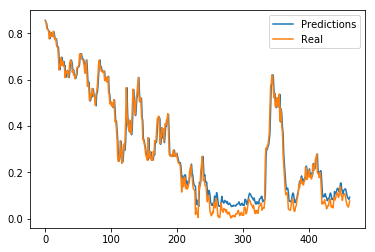

In [ ]:

#print(closed_X_val.shape,Volume_X_val.shape,ema6_X_val.shape,ema12_X_val.shape,ema26_X_val.shape,macd_X_val.shape,wrsi_X_val.shape,K_X_val.shape,D_X_val.shape)
preds = merged_model.predict([Volume_X_val,ema6_X_val,ema12_X_val,ema26_X_val,macd_X_val,wrsi_X_val,K_X_val,D_X_val,closed_X_val])
r2score = r2_score(closed_Y_val,preds[8])
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))
plt.plot(preds[8],label='Predictions')
plt.plot(closed_Y_val,label='Real')
plt.legend(loc='best')
plt.show()

In [ ]:
his = history.history
"""
for k in his.keys():
    plt.title(k)
    plt.plot(his[k])
    plt.show()
"""

'\nfor k in his.keys():\n    plt.title(k)\n    plt.plot(his[k])\n    plt.show()\n'

Average Errors: 0.016657762508380188


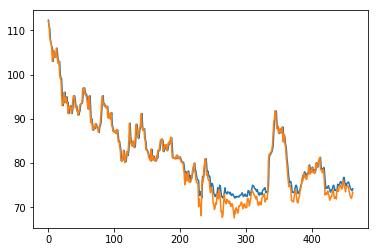

In [ ]:
tt = preds
d_len = len(preds[0])
#because the closed price is at index 8, but the original data it's at index 0
tmp = np.array(tt[-1]).reshape(d_len,1)
for i in range(0,len(preds)-1):
    tt[i] = np.array(tt[i])
tt[0] = tmp
tt = np.array(tt).T.reshape(d_len,9)
t = pd.DataFrame(data=mms.inverse_transform(tt))
close_pre = np.array(t.loc[:,0].values)
close_val = np.array(pd.DataFrame(mms.inverse_transform(X_val_df.values)).loc[1:,0].values)
plt.plot(close_pre)
plt.plot(close_val)
print("Average Errors:",np.mean(np.abs(close_pre-close_val)/close_val))

In [ ]:
prices= mms.inverse_transform(X_val[:-1])
#sr: spread rate
def ROR(preds,real,init_funds,period,sr=0.000,s=False):
    dict_Info = {
        'total_costs':[],
        'total_prices':[],
        'trade_times':[],
        'verbose':[],
        "RORs":[]
    }
    funds = init_funds
    profit=0
    total_cost=0
    total_price=0
    acc = []
    times = 0
    verbose = ''
    for i,p in enumerate(real):
        #print(dates_val[i],prices[i][0],preds[i],p,p-prices[i][0])
        if preds[i]>prices[i][0] and (abs(preds[i]-prices[i][0])/prices[i][0]) > sr:
            times +=1
            quantity = int(funds / preds[i])
            total_cost += prices[i][0] * quantity
            total_price += p * quantity
            funds += (p-prices[i][0]) * quantity
            verbose += "\nBuy Date: {} - {}\nPrediction: {}\nReal Price: {}\nSpread: {}\n".format(dates_val[i],prices[i][0],preds[i],p,p-prices[i][0])
        if (i+1)%period==0:
            #pass and not record the rate of prediciotn 'pre' < rate of threshold 'r'
            if total_cost != 0:
                dict_Info['total_costs'].append(total_cost*1000)
                dict_Info['total_prices'].append(total_price*1000)
                dict_Info['trade_times'].append(times)
                dict_Info['verbose'].append(verbose)
                dict_Info['RORs'].append((funds)/init_funds)
            times=0
            funds = init_funds
            total_cost=0
            total_price=0
            verbose = ''
    if times!=0:
        dict_Info['total_costs'].append(total_cost*1000)
        dict_Info['total_prices'].append(total_price*1000)
        dict_Info['trade_times'].append(times)
        dict_Info['verbose'].append(verbose)
        dict_Info['RORs'].append((funds)/init_funds*0.99575)
    return dict_Info,init_funds

In [ ]:
d,funds = ROR(close_pre,close_val,1000,20*12)
for i in range(len(d['total_prices'])):
    msg = 'Total Costs: {}\nInitial Funds: {}\nProfits: {}\nReturn Of Rate: {}\n'.format(d['total_costs'][i],
                                                                                    funds*1000,
                                                                                     (d['total_prices'][i]-d['total_costs'][i])*0.99575,
                                                                                     d['RORs'][i])
    print(d['verbose'][i])
    print(msg)
print("Average of Yearly ROI: {:.3f}".format(np.mean(d['RORs'])))


Buy Date: ['106/12/01'] - 99.09999999999998
Prediction: 99.23834228515625
Real Price: 99.0
Spread: -0.0999999999999801

Buy Date: ['106/12/04'] - 99.0
Prediction: 99.07441711425781
Real Price: 95.6
Spread: -3.4000000000000057

Buy Date: ['106/12/05'] - 95.6
Prediction: 95.72417449951172
Real Price: 93.0
Spread: -2.5999999999999943

Buy Date: ['106/12/07'] - 93.6
Prediction: 93.67578125
Real Price: 93.6
Spread: 0.0

Buy Date: ['106/12/08'] - 93.6
Prediction: 93.67578125
Real Price: 96.0
Spread: 2.4000000000000057

Buy Date: ['106/12/11'] - 96.0
Prediction: 96.03895568847656
Real Price: 94.1
Spread: -1.9000000000000057

Buy Date: ['106/12/12'] - 94.1
Prediction: 94.30945587158203
Real Price: 93.7
Spread: -0.3999999999999915

Buy Date: ['106/12/13'] - 93.7
Prediction: 93.77924346923828
Real Price: 94.9
Spread: 1.2000000000000028

Buy Date: ['106/12/14'] - 94.9
Prediction: 94.99622344970703
Real Price: 93.5
Spread: -1.4000000000000057

Buy Date: ['106/12/15'] - 93.5
Prediction: 93.5094985

In [ ]:
print(dates_val)

[['106/11/06']
 ['106/11/07']
 ['106/11/08']
 ['106/11/09']
 ['106/11/10']
 ['106/11/13']
 ['106/11/14']
 ['106/11/15']
 ['106/11/16']
 ['106/11/17']
 ['106/11/20']
 ['106/11/21']
 ['106/11/22']
 ['106/11/23']
 ['106/11/24']
 ['106/11/27']
 ['106/11/28']
 ['106/11/29']
 ['106/11/30']
 ['106/12/01']
 ['106/12/04']
 ['106/12/05']
 ['106/12/06']
 ['106/12/07']
 ['106/12/08']
 ['106/12/11']
 ['106/12/12']
 ['106/12/13']
 ['106/12/14']
 ['106/12/15']
 ['106/12/18']
 ['106/12/19']
 ['106/12/20']
 ['106/12/21']
 ['106/12/22']
 ['106/12/25']
 ['106/12/26']
 ['106/12/27']
 ['106/12/28']
 ['106/12/29']
 ['107/01/02']
 ['107/01/03']
 ['107/01/04']
 ['107/01/05']
 ['107/01/08']
 ['107/01/09']
 ['107/01/10']
 ['107/01/11']
 ['107/01/12']
 ['107/01/15']
 ['107/01/16']
 ['107/01/17']
 ['107/01/18']
 ['107/01/19']
 ['107/01/22']
 ['107/01/23']
 ['107/01/24']
 ['107/01/25']
 ['107/01/26']
 ['107/01/29']
 ['107/01/30']
 ['107/01/31']
 ['107/02/01']
 ['107/02/02']
 ['107/02/05']
 ['107/02/06']
 ['107/02/

In [ ]:
sn = input('Save Model:')
if sn != '':
    merged_model.save(sn+'.h5')